# Penguins and turtles classificator


## Data description

Dataset is split 50:50 between images of turtles and penguins. Each image contains exactly one instance of an object. Accompanying annotation information is a list of dictionaries. Bounding box coordinates are provided in Pascal VOC format. Category IDs include 1 (penguin) and 2 (turtle).

## Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D,
                                     AvgPool2D,
                                     MaxPooling2D,
                                     Dense,
                                     Flatten,
                                     BatchNormalization,
                                     GlobalAveragePooling2D,
                                     Activation,
                                     Dropout)

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0

from sklearn.metrics import (confusion_matrix,
                             precision_score,
                             recall_score)


from tensorflow.keras.utils import img_to_array, load_img
from keras.api._v2.keras import callbacks

from joblib import Parallel, delayed
import joblib

plt.style.use('seaborn-v0_8-pastel')
RANDOM_STATE = 42

In [6]:
def read_anotations(path, category):
  anotations =  pd.read_json(path)
  display(anotations.head(10))

  print('In the sample of :', len(anotations[category].unique()), 'classes')
  print()

  anotations.info()
  print()

  print('Quantity of missing values:')
  print(anotations.isna().sum())
  print()

  print('Number of values of each class in the sample:')
  print(anotations[category].value_counts())

  return anotations

In [53]:
train_anotations = read_anotations('/content/drive/MyDrive/penguins_and_turtles/train_annotations', 'category_id')

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,2,"[225, 298, 198, 185]",36630,[],0
3,3,3,2,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0
5,5,5,1,"[18, 110, 439, 461]",202379,[],0
6,6,6,1,"[318, 62, 321, 500]",160500,[],0
7,7,7,2,"[154, 255, 462, 366]",169092,[],0
8,8,8,1,"[328, 297, 246, 343]",84378,[],0
9,9,9,2,"[163, 215, 345, 265]",91425,[],0


In the sample of : 2 classes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            500 non-null    int64 
 1   image_id      500 non-null    int64 
 2   category_id   500 non-null    int64 
 3   bbox          500 non-null    object
 4   area          500 non-null    int64 
 5   segmentation  500 non-null    object
 6   iscrowd       500 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 27.5+ KB

Quantity of missing values:
id              0
image_id        0
category_id     0
bbox            0
area            0
segmentation    0
iscrowd         0
dtype: int64

Number of values of each class in the sample:
1    250
2    250
Name: category_id, dtype: int64


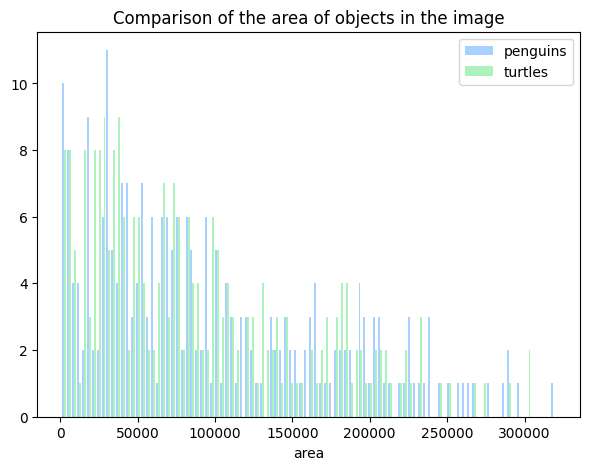

In [54]:
fig = plt.figure(figsize = (7, 5))
plt.hist(
    [train_anotations[train_anotations['category_id'] == 1].area,
    train_anotations[train_anotations['category_id'] == 2].area],
    bins = 100,
    alpha=0.8,
    label = ['penguins', 'turtles']
)
plt.xlabel('area')
plt.legend(loc='upper right');
plt.title('Comparison of the area of objects in the image');


**The objects are identical in area. There are no big differences.**

In [9]:
# data for testing

test_anotations = read_anotations('/content/drive/MyDrive/penguins_and_turtles/valid_annotations', 'category_id')

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[227, 93, 298, 525]",156450,[],0
1,1,1,2,"[211, 198, 428, 259]",110852,[],0
2,2,2,2,"[0, 243, 512, 267]",136704,[],0
3,3,3,1,"[128, 178, 457, 354]",161778,[],0
4,4,4,1,"[168, 131, 296, 469]",138824,[],0
5,5,5,1,"[6, 121, 445, 471]",209595,[],0
6,6,6,2,"[63, 161, 438, 322]",141036,[],0
7,7,7,1,"[188, 252, 254, 276]",70104,[],0
8,8,8,1,"[375, 237, 189, 315]",59535,[],0
9,9,9,1,"[364, 223, 141, 246]",34686,[],0


In the sample of : 2 classes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            72 non-null     int64 
 1   image_id      72 non-null     int64 
 2   category_id   72 non-null     int64 
 3   bbox          72 non-null     object
 4   area          72 non-null     int64 
 5   segmentation  72 non-null     object
 6   iscrowd       72 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 4.1+ KB

Quantity of missing values:
id              0
image_id        0
category_id     0
bbox            0
area            0
segmentation    0
iscrowd         0
dtype: int64

Number of values of each class in the sample:
1    36
2    36
Name: category_id, dtype: int64


In [10]:
# change numbers on image names in column

def change_values(path, anotation):
  names_images = sorted(os.listdir(path))

  for i in range(len(names_images)):
    anotation['image_id'][i] = names_images[i]

  for i in range(len(names_images)):
    anotation['category_id'][i] = str(anotation['category_id'][i])

  return anotation

In [11]:
train_anotations = change_values('/content/drive/MyDrive/penguins_and_turtles/train', train_anotations)
display(train_anotations.sample(5))

<ipython-input-10-35a673bd1958>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation['image_id'][i] = names_images[i]
<ipython-input-10-35a673bd1958>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation['category_id'][i] = str(anotation['category_id'][i])


,id,image_id,category_id,bbox,area,segmentation,iscrowd
35,35,image_id_035.jpg,1,"[441, 59, 136, 561]",76296,[],0
47,47,image_id_047.jpg,2,"[147, 148, 383, 406]",155498,[],0
235,235,image_id_235.jpg,2,"[3, 255, 634, 288]",182592,[],0
313,313,image_id_313.jpg,2,"[14, 235, 608, 314]",190912,[],0
445,445,image_id_445.jpg,1,"[261, 90, 246, 550]",135300,[],0


In [12]:
test_anotations = change_values('/content/drive/MyDrive/penguins_and_turtles/valid', test_anotations)

<ipython-input-10-35a673bd1958>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation['image_id'][i] = names_images[i]
<ipython-input-10-35a673bd1958>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation['category_id'][i] = str(anotation['category_id'][i])


## Modeling and training



In [13]:
# create a generator

generator = ImageDataGenerator(rescale=1/255,
                               # augmentation
                               horizontal_flip=True,
                               rotation_range=30,
                               zoom_range=0.2,
                               validation_split = 0.2)

In [14]:
def input_images(anotation, path, sample_for, image_size, batch):
  images = generator.flow_from_dataframe(
      anotation,
      directory= path,
      x_col = 'image_id',
      y_col= 'category_id',
      subset = sample_for,
    # numpy array of y_col data
      class_mode = 'categorical',
    # size of images
      target_size = (image_size, image_size),
      batch_size = batch,
      seed=RANDOM_STATE)

  return images

In [15]:
path_train = '/content/drive/MyDrive/penguins_and_turtles/train'
train_images = input_images(train_anotations, path_train, 'training', 224, 25)

Found 400 validated image filenames belonging to 2 classes.


In [16]:
valid_images = input_images(train_anotations, path_train, 'validation', 224, 25)

Found 100 validated image filenames belonging to 2 classes.


In [17]:
features, target = next(train_images)

In [18]:
print('Input tensor:', features.shape)
print(target.shape)

Input tensor: (25, 224, 224, 3)
(25, 2)


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


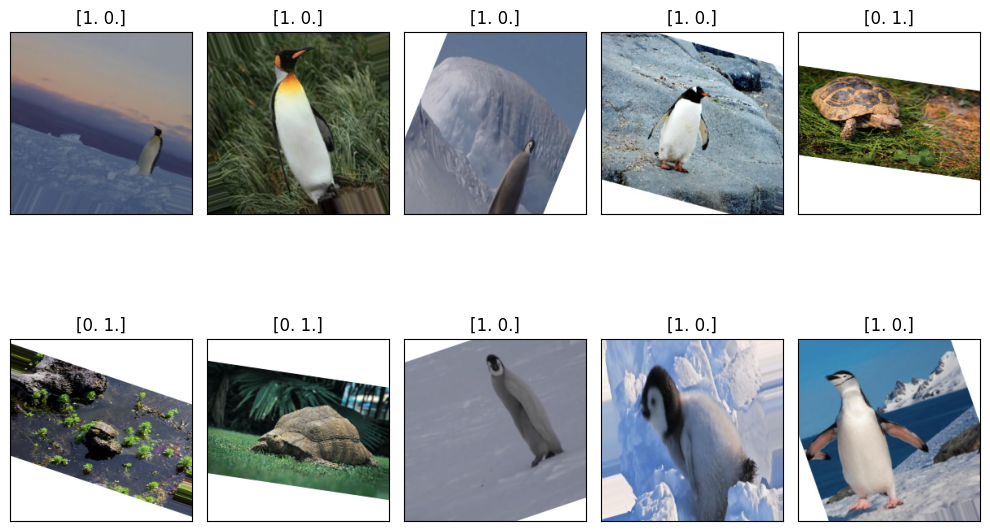

In [19]:
fig = plt.figure(figsize=(10, 10));
for i in range(10):
  fig.add_subplot(2, 5, i+1);
  plt.imshow(features[i]);
  plt.title(target[i]);
  plt.xticks([]);
  plt.yticks([]);
  plt.tight_layout();

### LeNet architecture

In [20]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), input_shape=features.shape[1:], activation='relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.99))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.99))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.99))


model.add(Flatten())

model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 84, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))

In [21]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 average_pooling2d (AverageP  (None, 110, 110, 16)     0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 average_pooling2d_1 (Averag  (None, 53, 53, 32)       0         
 ePooling2D)                                                     
                                                        

In [ ]:
# saving the model's learning progress

history = tf.keras.callbacks.History()

In [ ]:
%%timeit

model.fit(train_images,
          steps_per_epoch=len(train_images),
          validation_data = valid_images,
          validation_steps = len(valid_images),
          epochs = 20,
          callbacks=[history])

Epoch 1/20
16/16 [==============================] - 56s 3s/step - loss: 2.3129 - accuracy: 0.6675 - val_loss: 1.6258 - val_accuracy: 0.4500
Epoch 2/20
16/16 [==============================] - 57s 4s/step - loss: 2.3108 - accuracy: 0.7000 - val_loss: 1.1899 - val_accuracy: 0.6500
Epoch 3/20
16/16 [==============================] - 50s 3s/step - loss: 2.1571 - accuracy: 0.7050 - val_loss: 1.0978 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 56s 3s/step - loss: 2.0197 - accuracy: 0.7250 - val_loss: 1.9160 - val_accuracy: 0.6500
Epoch 5/20
16/16 [==============================] - 50s 3s/step - loss: 1.7597 - accuracy: 0.6975 - val_loss: 1.0892 - val_accuracy: 0.6600
Epoch 6/20
16/16 [==============================] - 50s 3s/step - loss: 1.5407 - accuracy: 0.7450 - val_loss: 0.8984 - val_accuracy: 0.6300
Epoch 7/20
16/16 [==============================] - 50s 3s/step - loss: 1.6675 - accuracy: 0.7475 - val_loss: 2.1784 - val_accuracy: 0.4700
Epoch 8/20
16/16 [==

KeyboardInterrupt: ignored

In [ ]:
with open('history_v4.0.json', 'w') as f:
    json.dump(history.history, f)
joblib.dump(model, 'model_v4.0_img.pkl')

['model_v4.0_img.pkl']

In [28]:
model = joblib.load('/content/drive/MyDrive/penguins_and_turtles/models/model_v4.0_img.pkl')

In [49]:
history = pd.read_json('/content/drive/MyDrive/penguins_and_turtles/models/history_v4.0.json')
display(history.tail())

,loss,accuracy,val_loss,val_accuracy
104,0.123354,0.9675,1.031874,0.83
105,0.043932,0.9800,0.997549,0.81
106,0.086563,0.9775,0.728792,0.84
107,0.040811,0.9875,0.730323,0.86
108,0.013526,0.9975,0.746172,0.85


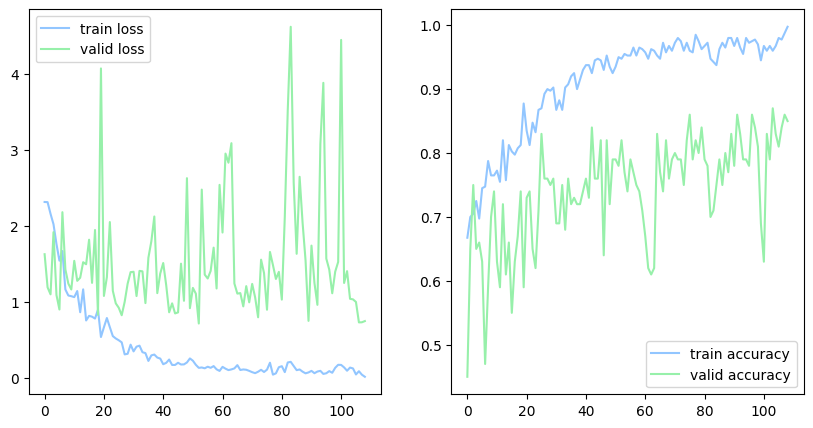

In [50]:
from matplotlib import legend
fig, ax = plt.subplots(1, 2, figsize = (10, 5));

ax[0].plot(history['loss'], label='train loss');
ax[0].plot(history['val_loss'], label='valid loss');
ax[0].legend();

ax[1].plot(history['accuracy'], label='train accuracy');
ax[1].plot(history['val_accuracy'], label='valid accuracy');
ax[1].legend();

### EfficientNetV2B0 backbone


In [57]:
# number of classes
class_count=2

# learning rate
lr= .001

# input shape of images
img_shape = (224, 224, 3)

backbone=tf.keras.applications.EfficientNetV2B0(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=img_shape,
                                                  pooling='max')
backbone.trainable=True

# output tensor
x=backbone.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)

x=Dropout(rate=.4, seed=RANDOM_STATE)(x)
output=Dense(class_count, activation='softmax')(x)

model_pre=Model(inputs=backbone.input, outputs=output)
model_pre.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# add 2 callbacks, reduce learning rate on plateau and early stopping

history_pre = tf.keras.callbacks.History()

rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.4,  patience=2,
                                            verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
callbacks=[rlronp, estop, history_pre]


In [60]:
#%%timeit

history_pre=model_pre.fit(x=train_images, epochs=20, verbose=1, callbacks=callbacks,  validation_data=valid_images,
                          validation_steps=None,  shuffle=True,  initial_epoch=0)

Epoch 1/20
16/16 [==============================] - 178s 9s/step - loss: 7.6468 - accuracy: 0.8125 - val_loss: 7.9656 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - 119s 7s/step - loss: 6.6296 - accuracy: 0.9125 - val_loss: 6.6938 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - 120s 8s/step - loss: 5.9870 - accuracy: 0.9300 - val_loss: 6.1451 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 4/20
16/16 [==============================] - 120s 8s/step - loss: 5.3935 - accuracy: 0.9650 - val_loss: 5.5209 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/20
16/16 [==============================] - 117s 7s/step - loss: 4.9637 - accuracy: 0.9525 - val_loss: 5.1049 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 6/20
16/16 [==============================] - 118s 7s/step - loss: 4.6188 - accuracy: 0.9375 - val_loss: 4.5091 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 7/20
16/16 [==============================] - 121s 8s/step - loss: 4.2

KeyboardInterrupt: ignored

In [78]:
# save the model
import pickle

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history_pre.history, file_pi)
joblib.dump(model_pre, 'model_EfNet_v2.0.pkl')

['model_EfNet_v2.0.pkl']

In [95]:
with open('/content/drive/MyDrive/penguins_and_turtles/models/trainHistoryDict', 'rb') as file_pi:
    history_pre = pd.DataFrame(pickle.load(file_pi))
display(history_pre.tail(5))

,loss,accuracy,val_loss,val_accuracy,lr
29,1.053914,1.0000,1.076537,0.96,0.001
30,1.015847,0.9950,0.984447,0.99,0.001
31,0.959874,0.9950,1.068414,0.88,0.001
32,0.901621,1.0000,0.933194,0.97,0.001
33,0.902182,0.9725,0.987473,0.94,0.001


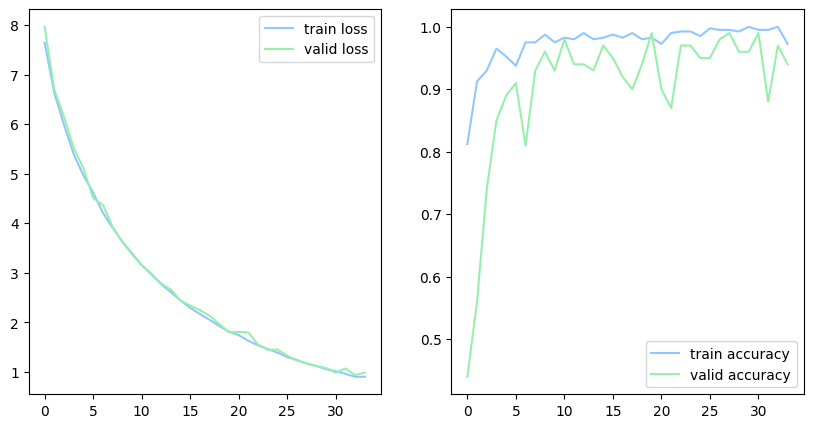

In [96]:
from matplotlib import legend
fig, ax = plt.subplots(1, 2, figsize = (10, 5));

ax[0].plot(history_pre['loss'], label='train loss');
ax[0].plot(history_pre['val_loss'], label='valid loss');
ax[0].legend();

ax[1].plot(history_pre['accuracy'], label='train accuracy');
ax[1].plot(history_pre['val_accuracy'], label='valid accuracy');
ax[1].legend();

## Testing

In [97]:
test_path = '/content/drive/MyDrive/penguins_and_turtles/valid'
test_anotations = change_values(test_path, test_anotations)
display(test_anotations.sample(5))

,id,image_id,category_id,bbox,area,segmentation,iscrowd
9,9,image_id_009.jpg,1,"[364, 223, 141, 246]",34686,[],0
5,5,image_id_005.jpg,1,"[6, 121, 445, 471]",209595,[],0
10,10,image_id_010.jpg,2,"[155, 173, 485, 360]",174600,[],0
13,13,image_id_013.jpg,2,"[126, 414, 393, 151]",59343,[],0
36,36,image_id_036.jpg,2,"[56, 186, 543, 274]",148782,[],0


In [100]:
test_images = input_images(test_anotations, test_path, None, 224, 12)

Found 72 validated image filenames belonging to 2 classes.


In [102]:
features_test, target_test = next(test_images)

In [111]:
# testing model

results = model_pre.evaluate(features_test, target_test)
print('test loss, test acc:', results)

1/1 [==============================] - 1s 615ms/step - loss: 0.9595 - accuracy: 0.9167
test loss, test acc: [0.9594637751579285, 0.9166666865348816]


## Conclusions

It was necessary to create an image classifier.
During experiments with various network parameters, train_accuracy = 0.91 was achieved using a pre-trained EffisienNet and transfer learning.

What can be done to improve the metric:

1) train the model on an additional number of epochs;

2) add new images and increase the percentage of augmentation;

3) try other network architectures, change the size of the convolution kernel and the counts of filters;

4) increase the size of the input vector to highlight more patterns, etc.